<a href="https://colab.research.google.com/github/joanby/trading-algoritmico-analisis-tecnico/blob/main/ES_TA_Cap%C3%ADtulo_05_Backtesting_Vectorizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px">
<img alt="Colaboratory logo" height="45px" src="https://static-881c.kxcdn.com/wp-content/uploads/2016/03/frogamesLogoFull4.png" align="left" hspace="10px" vspace="0px"></p>

# BackTesting Vectorizado
El backtesting es una parte esencial del trading. En efecto, es importante comprender el comportamiento de nuestra estrategia en el pasado para poder considerar los del futuro.

### Contenido

* Sortino Beta Alpha
* Drawdown 
* Crear la función BackTest para evaluar la estrategia en las secciones posteriores

</br>


💰 Únete a la comunidad de [Discord](https://discord.gg/wXjNPAc5BH)

📚 Puedes leer nuestro libro en [Amazon](https://www.amazon.com/gp/product/B09HG18CYL)

🖥️ El canal de [YouTube de Quantreo's](https://www.youtube.com/channel/UCp7jckfiEglNf_Gj62VR0pw) (en inglés) y el de [Frogames](https://www.youtube.com/channel/UCMUxXNYrVCv6-bQakhomvBg) en español

### Entorno

In [ ]:
!pip install yfinance    
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 22.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel 

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import ta
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

### Función

In [ ]:
def RSI(val, neutral, window):
  """ 
        ------------------------------------------------------------------------------
        | Output: La función da los rendimientos de la estrategia RSI                |
        ------------------------------------------------------------------------------
        | Inputs: -val (type dataframe pandas): Valores de entrada de la acción      |
        |         -neutral (float): Valor neutral, es decir, zona de no acción       |
        |         -window (float): período de balanceo para el RSI                   |
        ------------------------------------------------------------------------------
  """

  # Print Error if there is no column Adj Close in the dataframe
  if "Adj Close" not in val.columns:
    ValueError("Necesitamos tener un nombre de columna Adj Close porque todos los cálculos se refieren a esta columna")
  
  val["rsi"] = ta.momentum.RSIIndicator(val["Adj Close"], window=window).rsi()


  
  """Señal de compra en largo """
  # Colocamos el umbral
  overbuy = 70
  neutral_buy = 50 + neutral

  # Poner valores nan para las columnas de la señal larga
  val["signal_long"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # Necesitamos definir la señal de apertura en largo (RSI ayer<55 y RSI hoy>55)
  val.loc[(val["rsi"]>neutral_buy) & (val["yersteday_rsi"]<neutral_buy), "signal_long"] = 1

  # Necesitamos definir la señal cierre en largo (RSI ayer>55 y RSI hoy<55) Señal falsa
  val.loc[(val["rsi"]<neutral_buy)&(val["yersteday_rsi"]>neutral_buy), "signal_long"] = 0

  # Necesitamos definir la señal cierre en largo (RSI ayer<70 y RSI hoy>70) Señal de sobrecompra
  val.loc[(val["rsi"]>overbuy)&(val["yersteday_rsi"]<overbuy), "signal_long"] = 0



  """Señal de venta en corto """
  # Colocamos el umbral
  oversell = 30
  neutral_sell = 50 - neutral

  # Poner valores nan para las columnas de la señal larga
  val["signal_short"] = np.nan
  val["yersteday_rsi"] = val["rsi"].shift(1)
  # Necesitamos definir la señal de apertura en corto (RSI ayer>45 y RSI hoy<45)
  val.loc[(val["rsi"]<neutral_sell) & (val["yersteday_rsi"]>neutral_sell), "signal_short"] = -1

  # Necesitamos definir la señal de cierre en corto (RSI ayer<45 y RSI hoy>45) Señal falsa
  val.loc[(val["rsi"]>neutral_sell)&(val["yersteday_rsi"]<neutral_sell), "signal_short"] = 0

  # Necesitamos definir la señal de cierre en corto (RSI ayer>30 y RSI hoy<30) Señal de sobre venta
  val.loc[(val["rsi"]<oversell)&(val["yersteday_rsi"]>oversell), "signal_short"] = 0

  """Calcular el retorno """
  # Calculamos el porcentaje de variación del activo
  val["pct"] = val["Adj Close"].pct_change(1)

  # Calculamos las posiciones
  val["Position"] = (val["signal_short"].fillna(method="ffill")+ val["signal_long"].fillna(method="ffill"))

  # Calculamos el valor de retorno de la estrategia
  val["return"] = val["pct"]*(val["Position"].shift(1))

  return val["return"]

# Sección 1: Sortino Beta Alpha

###### Sortino
El índice de Sortino es una estadística similar al índice de Sharpe con la misma interpretación. Sin embargo, el cálculo es ligeramente diferente. En efecto, en el índice de Sortino sólo se tiene en cuenta la volatilidad de las ganancias negativas porque es lo que tememos y no las ganancias alcistas que nos hacen ganar dinero. <br>
<p align="center">
$Sortino = \frac{\mu }{\sigma_{down}}$
<p> <br>

* SortinoRatio < 0 : Inversión no rentable porque las ganancias son negativas.
* SortinoRatio < 1: Inversión rentable, pero el riesgo de la inversión es mayor que la rentabilidad.
* SortinoRatio > 1: Inversión muy rentable porque el riesgo es menor que el rendimiento.


In [ ]:
# Preparar los datos 
f = yf.download("GOOG", end="2021-01-01")
return_serie = RSI(f,5, 14)

# Calcular el índice de Sortino
mean = np.mean(return_serie) #252
vol = np.std(return_serie[return_serie<0]) #np.sqrt(252)
sortino = np.sqrt(252)*mean/vol

print(f"Sortino: {'%.3f' % sortino}")

[*********************100%***********************]  1 of 1 completed
Sortino: -0.162


###### Beta
La beta es un estadístico que indica la relación entre las variaciones de nuestra cartera y las del mercado que está representado por un índice (por ejemplo el SP500). <br>

<p align="center">
$Beta = \frac{Cov(r_{M},r_{PF}) }{Var(r_{M})}$
<p> <br>



* abs(Beta) < 1: Es bueno porque significa que la cartera tiene una variación menor que el índice. (Si beta=0,9 significa que si el índice varía en 1 la cartera varía en 0,9)
* abs(Beta) > 1: No es bueno porque significa que slau cartera tiene una variación mayor que el índice. (Si beta=1,1 significa que si el índice varía de 1 la cartera varía en 1,1)

*abs(-x) = x = abs(x) (abs da sólo el valor de la variable no el signo)*

In [ ]:
# Necesitamos calcular la covarianza entre el mercado y la cartera 
sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
sp500.name = "SP500"

# Los concatenamos para hacer las covarianzas
val = pd.concat((return_serie, sp500), axis=1).dropna()
val

[*********************100%***********************]  1 of 1 completed


,return,SP500
Date,,
2014-05-22,0.011356,0.002362
2014-05-23,0.014017,0.004248
2014-05-27,0.023973,0.005988
2014-05-28,-0.007545,-0.001114
2014-05-29,-0.002849,0.005367
...,...,...
2020-12-24,0.000000,0.003537
2020-12-28,0.000000,0.008723
2020-12-29,-0.009780,-0.002227


In [ ]:
# Calculamos la matriz de covarianzas
cov_var_mat = np.cov(val.values, rowvar=False)
cov_var_mat

array([[ 1.10851791e-04, -1.03896556e-05],
       [-1.03896556e-05,  1.29870452e-04]])

In [ ]:
# Calculamos beta 
cov = cov_var_mat[0][1]
var = cov_var_mat[1][1]

beta = cov/var

print(f"Beta: {'%.3f' % beta}")

Beta: -0.080


###### **Alpha**
El alfa es una estadístico que indica si la cartera supera al mercado en términos de rentabilidad del riesgo. <br>

<p align="center">
$Alpha = r_{PF} - \beta*(r_{PF} - r_{f}) - r_{f}$
<p> <br>


* alfa > 0: La cartera supera al mercado en términos de rentabilidad del riesgo
* alfa < 0: la cartera tiene un rendimiento inferior al del mercado en términos de riesgo-rendimiento



In [ ]:
# Calculamos alpha 
alpha = (252 * mean * (1-beta))*100
print(f"Alpha: {'%.1f' % alpha} %")

Alpha: -3.1 %


# Sección 2: Drawdown

El drawdown (reducción) es una medida del riesgo de la estrategia. Una estadística interesante para conocer el rendimiento del algoritmo es el drawdown máximo. En efecto, representa la pérdida máxima de una estrategia durante un período de tiempo que nos permite comprender si la estrategia es arriesgada y, por tanto, elegirla en función de nuestro nivel de aversión al riesgo.

In [ ]:
def drawdown_function(serie):

  # Calculamos la suma de los rendimientos
  cum = serie.dropna().cumsum() + 1

  # Calculamos el máximo de la suma en el período (máximo acumulado) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # Calculamos el drawdown
  drawdown = cum/running_max - 1
  return drawdown

In [ ]:
# Calculamos el drawdown
drawdown = drawdown_function(return_serie)
drawdown

Date
2014-05-22    0.000000
2014-05-23    0.000000
2014-05-27    0.000000
2014-05-28   -0.007190
2014-05-29   -0.009905
                ...   
2020-12-24   -0.226287
2020-12-28   -0.226287
2020-12-29   -0.235512
2020-12-30   -0.235512
2020-12-31   -0.235512
Name: return, Length: 1666, dtype: float64

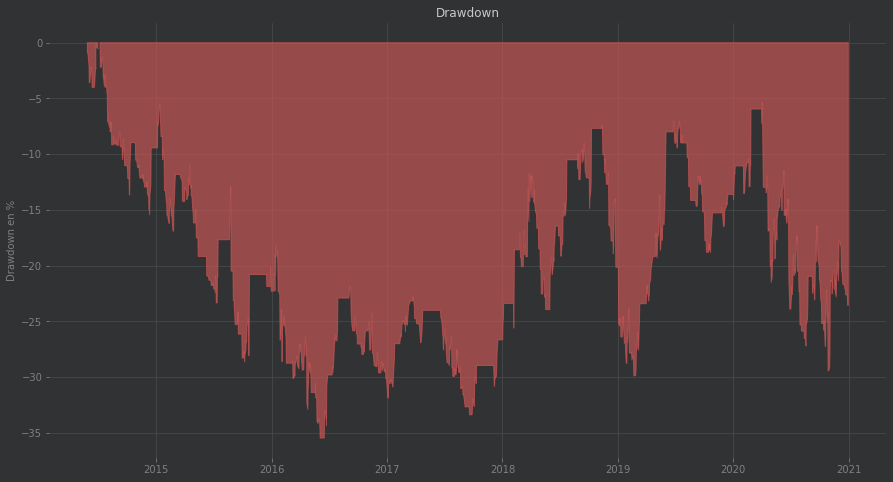

In [ ]:
# Adaptar el tamaño de la figura
plt.figure(figsize=(15,8))

# Representar el drawdown
plt.fill_between(drawdown.index, drawdown*100, 0,
                 drawdown, color="#CE5757", alpha=0.65)

# Añadimos el título
plt.title("Drawdown")

# Etiqueta del eje de la y
plt.ylabel("Drawdown en %")

plt.show()


In [ ]:
# Cálculo del drawdown máximo
max_drawdown = -np.min(drawdown)*100
print(f"Max drawdown: {'%.1f' % max_drawdown} %")

Max drawdown: 35.5 %


# Sección 3: Crear la función BackTest para evaluar la estrategia en las secciones posteriores

In [ ]:
def BackTest(serie, annualiazed_scalar=252):

  # Importar el benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Cambiar el nombre
  sp500.name = "SP500"

  # Concatenar los retornos y el sp500
  val = pd.concat((serie,sp500), axis=1).dropna()
  # Calcular el drawdown
  drawdown = drawdown_function(serie)*100
  
  # Calcular el max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown en %", size=11)

  # Plot the graph
  plt.show()


  # Calcular el índice sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Calcular el índice  beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Calcular el índice  alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Imprimir los estadísticos
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

[*********************100%***********************]  1 of 1 completed


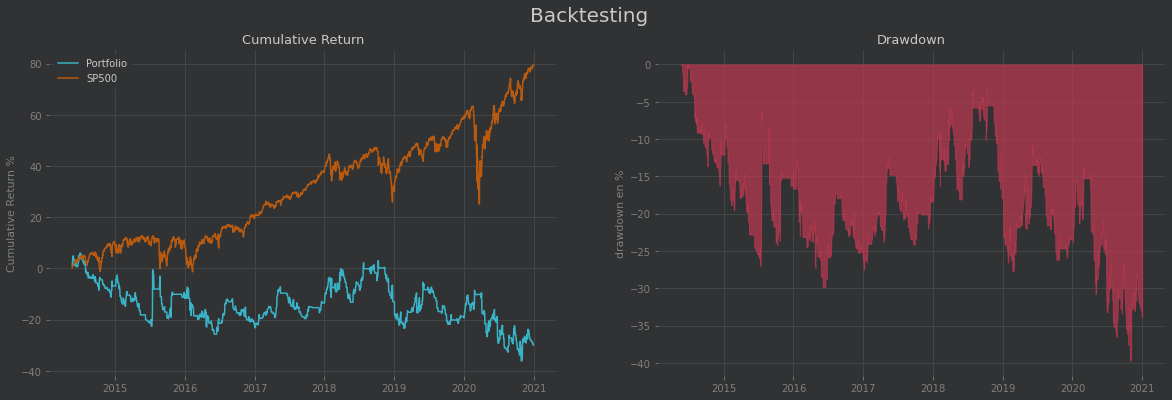

Sortino: -0.249
Beta: -0.069
Alpha: -4.833 %
MaxDrawdown: 39.75 %


In [ ]:
return_serie = RSI(f,5, 14)
BackTest(return_serie, annualiazed_scalar=252)

Sortino: -0.162
Beta: -0.08
Alpha: -3.096 %
MaxDrawdown: 35.466 %
